# Notes on Chapters 1 - 3 in Sutton RL book

## Chapter 1

The following is my summary and paraphrasing of Chapter 1 in Sutton and Barto's Reinforcement Learning: An Introduction

### 1.1

"Reinforcement learning is learning what to do - how to map situations to actions - so as to maximize a numerical reward signal." For tic-tac-toe this would be something like learning how to take actions to maximize a win rate.

"A learning agent must be able to sense the state of its environment to some extent and must be able to take some actions to affect the state." In terms of tic-tac-toe this means the agent needs to be able to observe the state of the board and it needs to be able to place Xs and Os where it chooses.

"The agent must have a goal or goals relating to the state of the environment"; here the goal would be to win.

"Exploration vs Exploitation - To get a lot of reward, an agent has to use actions it has used in the past that it knows produces reward, but to find reward giving actions, an agent must try actions its never tried before. So the agent has to try a variety of actions and progressively favor those that appear best." In tic-tac-toe this could be equivalent to continually trying new moves in hopes of uncovering a better strategy than what has already been found.

### 1.3

4 main subelements of a reinforcement learning system:
    - Policy
    - Reward signal
    - Value function
    - Environment model (optional)

"Policy describes the learning agent's way of behaving at a given time, it provides a mapping from the state of the environment to what action to take in that state." In tic-tac-toe, the policy would describe what move to make depending on the state of the board.

"The reward signal defines the goal in an RL problem." At each time step, the environment sends a reward value to the agent. The agent's goal is to maximize the reward it receives over long period of time. In tic-tac-toe, the reward could come from winning, so the agent would want to make moves that are winning moves so that it can receive more reward.

"Since the reward signal operates at each time step, it is a short-term value; the value function declares what is good in the long run." The value of a state is the total reward an agent can expect to gather over the future, starting with that state. Values indicate the long-term desirability of states, taking into account the states that are likely to follow, and the available reward in those states. In tic-tac-toe, a high value move might be one that likely leads to a winning sequence of moves.

"When we are making action choices, we use values as judgment, not rewards." We want actions that yield the highest value, not the highest reward, because these are the best actions over the long run. It's much harder to determine values than rewards; rewards are given to us by the environment, while values must be estimated using an agent's past experiences and observations. 

"The model of the environment mimics the environment, or it allows inferences to be made about how the environment will behave." i.e. given a state and action, a model might be able to predict the next state and reward. We use models for planning. In tic-tac-toe, this might mean a model of the board and the other player where a move can be made in the model and the model tries to return a prediction of the opponents responding move and the reward from that next state.

### 1.5

Tic-tac-toe example. 

Let's consider draws and losses to be equally bad. How can we build a player that will find the imperfections in its opponent's play and learn to maximize its chances of winning?

This can't be solved readily through classical techniques. The minimax solution from game theory doesn't work because it asssumes a particular way of playing by the opponent, and something like dynamic programming requires as input complete specifications of the opponent, including the probabilities of each move the opponent could make in each board state. 

We could play lots of games against the opponent and learn some model of the opponents behavior, and then apply dynamic programming to those estimated move probabilities from the model to compute the optimal moves.

An evolutionary method would search the space of possible policies for one with a high probability of winning against the opponent. In this case, the policy is a rule that tells the player what move to make for every state of the game.

Tic-tac-toe with method making use of a value function:

We set up a table of numbers, one for each state of the game. Each number is the latest estimate of the probability of winning from that state. This estimate is considered the state's value, and the whole table is the learned value function. 

If we are playing X's, then each state where there are 3 X's in a row has a probability of 1, since we've already won, and each state where there are 3 O's in a row or the board is full has a probability of 0, since we've either lost or drawn and we can't win from that state. Make the initial values of all other states .5, to guess an initial 50% probability of winning.

Play lots of games against the opponent. To pick our next move we look at the states that would result from each possible move and check the corresponding win probability in the table. Most often we move greedily, picking the move that leads to the state with the highest value. But sometimes we randomly select a move from the table, and these are our exploratory moves, which allow us to see states that we might otherwise never find. 

While playing, we change the values of the states we wind up in. We try to make them more accurate estimates of the probability of winning. The current value of the earlier state is updated to be closer to the value of the later state. This is done by moving the value of the earlier state a fraction of the way towards the value of the later state.
    - Let s be the state before the greedy move
    - s' is the state after the greedy move
    - V(s) is the update to the estimated value of s
    - alpha is learning rate
    
V(s) <-- V(s) + alpha * [V(s') - V(s)]

This update rule is an example of temporal difference learning, because its changes are based on a difference at two different times (V(s') - V(s)).

If alpha is reduced to zero over time, this method converges for any fixed player to the true probabilities of winning for any given state, given optimal play by the method. If alpha isn't reduced all the way to zero over time, then this method also plays well against players that slowly change their style of playing.

## Tic-tac-toe code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## TODO:

- Fix gen_o_values function::DONE
- Start making changes to make more general for n by n tic-tac-toe
- Clean up code 

In [19]:
class tictactoe:
    def __init__(self):
        self.x_win = False
        self.o_win = False
        self.game_over = False
        self.v = dict()
        self.chars = [0, 1, 2]
        
    def gen_3_state_arr(self):
        arr = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    for t in range(3):
                        for u in range(3):
                            for s in range(3):
                                for q in range(3):
                                    for y in range(3):
                                        for z in range(3):
                                            tmp = np.array([self.chars[i], self.chars[j], self.chars[k], self.chars[t], self.chars[u], self.chars[s],
                                                       self.chars[q], self.chars[y], self.chars[z]]).reshape(3, 3)
                                            if self.check_legal(tmp, 3) == True:
                                                arr.append(tmp)
                                                
        return np.asarray(arr)
    
    def gen_4_state_arr(self):
        arr = []
        for a in range(3):
            for b in range(3):
                for c in range(3):
                    for d in range(3):
                        for e in range(3):
                            for f in range(3):
                                for g in range(3):
                                    for h in range(3):
                                        for i in range(3):
                                            for j in range(3):
                                                for k in range(3):
                                                    for l in range(3):
                                                        for m in range(3):
                                                            for n in range(3):
                                                                for o in range(3):
                                                                    for p in range(3):
                                                                        tmp = np.array([self.chars[a], self.chars[b], self.chars[c], self.chars[d], self.chars[e],
                                                                                        self.chars[f], self.chars[g], self.chars[h], self.chars[i], self.chars[j],
                                                                                        self.chars[k], self.chars[l], self.chars[m], self.chars[n], self.chars[o],
                                                                                        self.chars[p]]).reshape(4, 4)
                                                                        if self.check_legal(tmp, 4) == True:
                                                                            arr.append(tmp)
        return np.asarray(arr)
                                            
    
    def gen_x_values(self, state_arr):
        vals = []
        for i in range(len(state_arr)):
            value = self.check_over(state_arr[i], n)
            vals.append(value)
        vals = np.asarray(vals)
        vals = vals[vals < 3]
        return vals
    
    def gen_o_values(self, x_values):
        return 1 - x_values
    
    def check_legal(self, state, n):
        x_count, o_count, empty_count = 0, 0, 0
        state_cpy = np.copy(state).ravel()
        for i in range(len(state_cpy)):
            if state_cpy[i] == 1: x_count += 1
            elif state_cpy[i] == 2: o_count += 1
            elif state_cpy[i] == 0: empty_count += 1
        
        if x_count == o_count + 1 or x_count == o_count:
            # check for X and O win
            if self.check_over(state, n) == 3:
                return False
            # check for O win and num Xs = num Os
            if x_count != o_count and self.check_over(state, n) == 0:
                return False
            # check for X win and num Xs = num Os + 1
            if self.check_over(state, n) == 1 and x_count != o_count + 1:
                return False
            return True
        return False

        
    def check_over(self, state, n):
        x_vec = np.ones(n, dtype=int)
        o_vec = np.full(n, 2, dtype=int)
        x_win, o_win = 0, 0
        
        state_diag = np.diag(state).astype(int)
        state_rev_diag = np.fliplr(state).diagonal().astype(int)
        
        if np.array_equal(state_diag, x_vec) or np.array_equal(state_rev_diag, x_vec):
            x_win += 1
        
        if np.array_equal(state_diag, o_vec) or np.array_equal(state_rev_diag, o_vec):
            o_win += 1
        
        cols = [state[:, i].astype(int) for i in range(len(state))]
        #cols = [state[:, 0].astype(int), state[:, 1].astype(int), state[:, 2].astype(int)]
        #rows = [state[0, :].astype(int), state[1, :].astype(int), state[2, :].astype(int)]
        rows = [state[i, :].astype(int) for i in range(len(state))]
        
        for i in cols:
            if np.array_equal(i, x_vec):
                x_win += 1
            elif np.array_equal(i, o_vec):
                o_win += 1
        
        for i in rows:
            if np.array_equal(i, x_vec):
                x_win += 1
            elif np.array_equal(i, o_vec):
                o_win += 1
        
        if x_win >= 1 and o_win == 1:
            return 3
        elif x_win >= 1:
            return 1
        elif o_win == 1:
            return 0
        else:
            return 0.5
    
    def human_viz(self, state):
        tmp_board = np.empty(state.shape, dtype=str)
        for i in range(len(state)):
            for j in range(len(state[i])):
                if state[i][j] == 1:
                    tmp_board[i][j] = 'X'
                elif state[i][j] == 2:
                    tmp_board[i][j] = 'O'
                elif state[i][j] == 0:
                    tmp_board[i][j] = '-'
        print(tmp_board)
        
    def find_next_move_slow(self, state_arr, state, player):
        tmp_states = []
        inds = []
        if player is 1:
            for i in range(len(state)):
                for j in range(len(state[i])):
                    tmp = np.copy(state)
                    if tmp[i][j] == 0:
                        tmp[i][j] = 1
                        tmp_states.append(tmp)
            
            for i in range(len(tmp_states)):
                for j in range(len(state_arr)):
                    if np.array_equal(tmp_states[i], state_arr[j]):
                        inds.append(j)
            return inds
        
        if player is 2:
            for i in range(len(state)):
                for j in range(len(state[i])):
                    tmp = np.copy(state)
                    if tmp[i][j] == 0:
                        tmp[i][j] = 2
                        tmp_states.append(tmp)
                        
            for i in range(len(tmp_states)):
                for j in range(len(state_arr)):
                    if np.array_equal(tmp_states[i], state_arr[j]):
                        inds.append(j)
            return inds
    
    def find_next_move(self, state_arr, state, player):
        tmp_states = []
        inds = []
        sort_inds = np.asarray(np.where(state == 0))
        if player is 1:
            for i in range(sort_inds.shape[1]):
                tmp = np.copy(state)
                tmp_ind = sort_inds[:, i]
                tmp[tmp_ind[0], tmp_ind[1]] = 1
                inds.append(np.argmax((tmp == state_arr).sum(axis=1).sum(axis=1)))
            return inds
        
        if player is 2:
            for i in range(sort_inds.shape[1]):
                tmp = np.copy(state)
                tmp_ind = sort_inds[:, i]
                tmp[tmp_ind[0], tmp_ind[1]] = 2
                inds.append(np.argmax((tmp == state_arr).sum(axis=1).sum(axis=1)))
            return inds
        
    def get_current_state_index(self, state, state_arr):
        for i in range(len(state_arr)):
            if np.array_equal(state_arr[i], state):
                return state, i
        return 'Current state invalid.'
    
    def human_play(self, state_arr, agent, agent_char):
        state = state_arr[0]
        iter_count = 0
        if agent_char is 1:
            while self.check_over(state, 3) == 0.5 and iter_count <= 8:
                cur_state_ind = self.get_current_state_index(state, state_arr)
                if iter_count % 2 == 0:
                    move_inds = self.find_next_move(state_arr, state, 1)
                    new_move_ind = agent.exploit_learned_probs(move_inds, cur_state_ind[1], .1)
                    state = state_arr[new_move_ind]
                else:
                    self.human_viz(state)
                    move_valid = False
                    while move_valid == False:
                        human_move = input('Input your move coordinates, separated by a comma: ')
                        coord_1, coord_2 = int(human_move[0]), int(human_move[-1])
                        if state[coord_1, coord_2] != 0:
                            print('Invalid move, try again.')
                            continue
                        tmp_state = np.copy(state)
                        tmp_state[coord_1, coord_2] = 2
                        if self.check_legal(tmp_state, 3) == True:
                            state = tmp_state
                            move_valid = True
                iter_count += 1

        if agent_char is 2:
            while self.check_over(state, 3) == 0.5 and iter_count <= 8:
                cur_state_ind = self.get_current_state_index(state, state_arr)
                if iter_count % 2 != 0:
                    move_inds = self.find_next_move(state_arr, state, 2)
                    new_move_ind = agent.exploit_learned_probs(move_inds, cur_state_ind[1], .1)
                    state = state_arr[new_move_ind]
                else:
                    self.human_viz(state)
                    move_valid = False
                    while move_valid == False:
                        human_move = input('Input your move coordinates, separated by a comma: ')
                        coord_1, coord_2 = int(human_move[0]), int(human_move[-1])
                        if state[coord_1, coord_2] != 0:
                            print('Invalid move, try again.')
                            continue
                        tmp_state = np.copy(state)
                        tmp_state[coord_1, coord_2] = 1
                        if self.check_legal(tmp_state, 3) == True:
                            state = tmp_state
                            move_valid = True
                iter_count += 1

        self.human_viz(state)


In [3]:
ttt = tictactoe()

In [29]:
arr = ttt.gen_4_state_arr()

KeyboardInterrupt: 

In [14]:
class td_agent:
    def __init__(self, values, p_random_move, alpha_start):
        self.vals = values
        self.p_random_move = p_random_move
        self.alpha = alpha_start
    
    def alpha_anneal(self, alpha_start, alpha_end, num_iters):
        self.alpha -= (alpha_start - alpha_end)/num_iters 
    
    def get_move_update_values(self, move_inds, current_state_ind):
        if np.random.binomial(1, self.p_random_move) == 1:
            move_ind = np.random.randint(0, len(move_inds))
            move = move_inds[move_ind]
        else:
            greedy_move = np.argmax(self.vals[move_inds])
            move = move_inds[greedy_move]
            self.vals[current_state_ind] += self.alpha * (self.vals[move] - self.vals[current_state_ind])
        
        return move
    
    def exploit_learned_probs(self, move_inds, current_state_ind, learn=False):
        move = move_inds[np.argmax(self.vals[move_inds])]
        if learn == True:
            self.vals[current_state_ind] += self.alpha * (self.vals[move] - self.vals[current_state_ind])
        return move

In [20]:
game = tictactoe()
state_arr = game.gen_3_state_arr()

x_vals = np.load('/Users/jacobpettit/Documents/reinforcement-learning/BookNotes/x_game_vals_alpha_anneal.npy')
o_vals = game.gen_o_values(x_vals)

TD_x = td_agent(x_vals, .2, .4)
TD_o = td_agent(o_vals, .2, .4)

In [11]:
ts1 = state_arr[0]
# win probability should be 1
ts2 = np.array([1, 0, 1, 2, 2, 0, 1, 0, 2]).reshape(3, 3)
ts3 = np.array([1, 0, 1, 2, 1, 2, 0, 2, 0]).reshape(3, 3)
ts4 = np.array([1, 2, 1, 2, 0, 2, 1, 2, 1]).reshape(3, 3)
ts5 = np.array([2, 0, 0, 2, 1, 0, 1, 1, 2]).reshape(3, 3)
# win probability should be 0
ts6 = np.array([2, 0, 2, 0, 1, 1, 2, 1, 1]).reshape(3, 3)
ts7 = np.array([2, 2, 0, 1, 0, 0, 1, 0, 1]).reshape(3, 3)
ts8 = np.array([2, 0, 2, 1, 2, 1, 1, 1, 0]).reshape(3, 3)
ts9 = np.array([1, 1, 0, 1, 2, 0, 2, 0, 0]).reshape(3, 3)
ts10 = np.array([1, 1, 0, 0, 1, 0, 2, 2, 0]).reshape(3, 3)

ts_inds = []
ts_ = [ts1, ts2, ts3, ts4, ts5, ts6, ts7, ts8, ts9, ts10]
for i in ts_:
    ts_inds.append(game.get_current_state_index(i, state_arr)[1])
    
print(TD_x.vals[ts_inds])

[0.56701349 0.99848589 0.67195    0.5        0.5        0.5
 0.5        0.45       0.455      0.3645    ]


In [16]:
x_wins, o_wins, draws = 0, 0, 0
x_win_states, o_win_states, draw_states = [], [], []    
for i in range(5000):
    iter_count = 0
    cur_state = state_arr[0]
    while game.check_over(cur_state, n) == 0.5 and iter_count <= 8:
        cur_state_ind = game.get_current_state_index(cur_state, state_arr)
        if iter_count % 2 == 0:
            move_inds = game.find_next_move(state_arr, cur_state, 1)
            new_move_ind = TD_x.get_move_update_values(move_inds, cur_state_ind[1])
            cur_state = state_arr[new_move_ind]
        else:
            move_inds = game.find_next_move(state_arr, cur_state, 2)
            new_move_ind = TD_o.exploit_learned_probs(move_inds, cur_state_ind[1])
            cur_state = state_arr[new_move_ind]
        iter_count += 1
    if game.check_over(cur_state, n) == 1:
        x_wins += 1
        x_win_states.append(cur_state)
    if game.check_over(cur_state, n) == 0:
        o_wins += 1
        o_win_states.append(cur_state)
    if game.check_over(cur_state, n) == .5:
        draws += 1
        draw_states.append(cur_state)
    TD_x.alpha_anneal(.4, .1, 5000)
    if i%1000 == 0:
        print('Iter:', i)
        print('X values for test states:', TD_x.vals[ts_inds])
        print('O values for test states:', TD_o.vals[ts_inds])
        print()
        np.save('x_game_vals_alpha_anneal.npy', TD_x.vals)
        #np.save('o_game_vals_alpha_anneal.npy', TD_o.vals)
        TD_o.vals = game.gen_o_values(TD_x.vals)

Iter: 0
X values for test states: [0.56701349 0.5        0.67195    0.5        0.5        0.5
 0.5        0.45       0.455      0.3645    ]
O values for test states: [0.43860133 0.5        0.32805    0.5        0.5        0.5
 0.5        0.55       0.545      0.6355    ]

Iter: 1000
X values for test states: [0.56701349 0.5        0.67195    0.5        0.5        0.5
 0.5        0.45       0.455      0.3645    ]
O values for test states: [0.43298651 0.5        0.32805    0.5        0.5        0.5
 0.5        0.55       0.545      0.6355    ]

Iter: 2000
X values for test states: [0.56701349 0.99848589 0.67195    0.5        0.5        0.5
 0.5        0.45       0.455      0.3645    ]
O values for test states: [0.43298651 0.5        0.32805    0.5        0.5        0.5
 0.5        0.55       0.545      0.6355    ]

Iter: 3000
X values for test states: [0.56701349 0.99848589 0.67195    0.5        0.5        0.5
 0.5        0.45       0.455      0.3645    ]
O values for test states: [0.432

In [21]:
game.human_play(state_arr, TD_o, 2)

[['-' '-' '-']
 ['-' '-' '-']
 ['-' '-' '-']]


Input your move coordinates, separated by a comma:  00


[['X' '-' '-']
 ['-' 'O' '-']
 ['-' '-' '-']]


Input your move coordinates, separated by a comma:  22


[['X' 'O' '-']
 ['-' 'O' '-']
 ['-' '-' 'X']]


Input your move coordinates, separated by a comma:  21


[['X' 'O' '-']
 ['-' 'O' '-']
 ['O' 'X' 'X']]


Input your move coordinates, separated by a comma:  02


[['X' 'O' 'X']
 ['-' 'O' 'O']
 ['O' 'X' 'X']]


Input your move coordinates, separated by a comma:  10


[['X' 'O' 'X']
 ['X' 'O' 'O']
 ['O' 'X' 'X']]


In [19]:
game.human_play(state_arr, TD_x, 1)

[['-' '-' '-']
 ['-' 'X' '-']
 ['-' '-' '-']]


Input your move coordinates, separated by a comma:  21


[['-' '-' 'X']
 ['-' 'X' '-']
 ['-' 'O' '-']]


Input your move coordinates, separated by a comma:  20


[['-' '-' 'X']
 ['-' 'X' '-']
 ['O' 'O' 'X']]


Input your move coordinates, separated by a comma:  12


[['X' '-' 'X']
 ['-' 'X' 'O']
 ['O' 'O' 'X']]


In [18]:
best_x_vals, best_o_vals = np.load('x_game_vals_fixed.npy'), np.load('o_game_vals_fixed.npy')

In [24]:
best_x_agent = td_agent(best_x_vals, .2)
best_o_agent = td_agent(best_o_vals, .2)

In [23]:
game.human_play(state_arr, best_x_agent, 1)

NameError: name 'best_x_agent' is not defined

In [28]:
game.human_play(state_arr, best_o_agent, 2)

[['-' '-' '-']
 ['-' '-' '-']
 ['-' '-' '-']]


Input your move coordinates, separated by a comma:  0,0


[['X' '-' '-']
 ['O' '-' '-']
 ['-' '-' '-']]


Input your move coordinates, separated by a comma:  2,2


[['X' 'O' '-']
 ['O' '-' '-']
 ['-' '-' 'X']]


Input your move coordinates, separated by a comma:  0,2


[['X' 'O' 'X']
 ['O' 'O' '-']
 ['-' '-' 'X']]


Input your move coordinates, separated by a comma:  2,0


[['X' 'O' 'X']
 ['O' 'O' 'O']
 ['X' '-' 'X']]


In [23]:
3**16

43046721

## Chapter 2

The following is my notes, summary, and paraphrasing of Chapter 2 in Sutton and Barto's Reinforcement Learning: An Introduction

### Short Summary of three of the key ideas from Chapter 2.

Imagine playing on a slot machine. We can say a couple of things about the characteristics of slot machines.
- There is no skill involved in winning.
- Provided that the machine is coded correctly, a win is always random according to some predefined probability distribution.
- The action you take on this time step doesn't change the action you should take on the next time step
- The action you take does not change the state of the slot machine.

Now, let's consider a k-armed bandit problem. In a k-armed bandit problem, we consider a slot machine with k arms, and each arm has a different win probability. If you could figure out the win probabilities (aka true action values) for each arm, then you could win more than losing over the long run. When we solve a k-armed bandit problem we are trying to estimate the true action values for a set of actions so that we can choose the optimal actions at each time step. In the case where the true action values are unchanging, this is called a stationary problem. When the true action values change over time, it is a nonstationary problem.

Now imagine you are playing a slot machine with 3 arms. It also has a display. The display can have three colors; red, green, and blue. Each time the color of the display changes, the true action values of the arms change as well. This is considered an associative problem. It is called this because now we must learn a policy which maps the situation of the environment to the optimal action. A sample, simple policy could be: if red, pull arm 1; if green, pull arm 2; if blue, pull arm 3. Associative problems also have the stationary and nonstationary cases.

Importantly, in the previous two example problems, your actions affected only the immediate reward you received (whether you won or not, or perhaps how much you won). And they did not change the state of the machine. Now, lets imagine that your actions can change the state of the machine, and thus impact not only the immediate reward, but the reward of playing the machine over the long run. So, you can take actions to change the color of the display. Perhaps you determine that you win the most when the light is red, and you are able to play long enough to figure out which actions maximize the time that the screen stays red. This we would consider to be the full reinforcement learning problem. This is because it has associative elements, learning to choose which arm to pull based on the color of the screen, as well as having our actions change the state of our environment.

### Multi-Armed Bandits

"The most important feature distinguishing reinforcement learning from other types of learning is that it uses training information that $evaluates$ the actions taken rather than $instructs$ by giving the correct actions."

If we used feedback that is only evaluating each move, this will tell us how good the action taken was, but not if it was the best or worst action we could've possibly taken.

Using feedback that is just instructive will only tell us the right action to take, regardless of the action that we took.

### 2.1: A $k$-armed Bandit Problem

The problem:

We repeatedly have to choose from among $k$ different actions. After each action, a reward is given, the reward is picked from an unchanging probability distribution that depends on the action chosen. The goal is to maximize the (expected) total reward over an arbitrary time period.

"This is the original form of the k-armed bandit problem, so named by analogy to a slot machine, or "one armed bandit", except that it has $k$ levers instead of one. Each action selection is like a play of one of the slot machine's levers, and the rewards are payoffs for hitting the jackpot. Through repeated action selections you are to maximize your chances of winning by concentrating your actions on the best levers."



In the k-armed bandit problem, each action we could choose has an expected or average reward given that action is chosen, we call this the $value$ of that action. 

Notation:
    - Action selected on time step t is A_t
    - Reward at time step t is R_t
    
So, the value of an action $a$, denoted as $q$<sub>*</sub> $(a)$ is our expected reward given that $a$ is picked.
    
$q$<sub>*</sub>($a$) = E[$R$<sub>t</sub> | $A$<sub>t</sub> = $a$]
    
If we knew the values of each action with certainty, it would be easy to solve the k-armed bandit problem, because we would just choose the action with the highest value at each time step.
We assume to not know the action values with certainty. At best we may have estimates. The estimated value of action $a$ at time step $t$ is denoted as $Q$<sub>t</sub>($a$).
    
We want $Q$<sub>t</sub>($a$) to be close to $q$<sub>*</sub>($a$). If we keep estimates of the action values, then at each time step there is an action with the greatest expected value. If we choose the action with that value, these types of actions are considered greedy actions. Choosing one a greedy action means you are exploiting your current knowledge of action values. 
    
Nongreedy actions are said to be exploring actions, because we are improving our estimate of the nongreedy action's value. 
    
"Exploitation is the right thing to do to maximize the expected reward on the one step, but exploration may produce the greater reward in the long run."
 
Since we can't possibly explore and exploit with one action, there's a balance to be struck between exploration and exploitation.    

In each specific case, if it is better to explore or exploit depends on a multitude of factors; the values of the estimates, uncertainties, and the number of steps left. Lots of different, sophisticated, methods exist to balance between exploration and exploitation for certain formulations of the k-armed bandit problem. Issue is, most of these methods make "strong assumptions about stationary and prior knowledge that are either violated or impossible to verify in applications and in the full reinforcement learning problem that we consider in subsequent chapters."
    
In chapter 2 we will cover several simple balancing methods for the k-armed bandit problem and we will see that they are superior to methods that always exploit. Balancing exploration and exploitation is a "distinctive challenge" in RL; our simple version of the k-armed bandit problem will allow us to show this in a very clear way.

### 2.2 Action-Value Methods

A natural way to estimate the true value of an action is to average the rewards received:

$Q$<sub>$t$</sub>($a$) = $\frac{\sum_{i=1}^{t - 1}R_i * 1}{\sum_{i=1}^{t-1} 1}$

Where $1$ is the same as $1_{predicate}$ in the textbook.

From text: the 1 in the formula above should be *1<sub>A<sub>i</sub>=a</sub>*

$1_{predicate}$ denotes a random variable that is 1 if $predicate$ is true and 0 if it isn't. If the denominator becomes zero, then we define $Q_t(a)$ by some other value, like 0. As the denominator grows towards infinity, by the law of large numbers, $Q_t(a)$ converges towards $q_*(a)$

This is called the sample-average method; estimates action values because each estimate is average of the sample of relevant rewards. 

Can write a greedy action selection method as: $A_t = argmax  (Q_t(a))$. Greedy action selection *always* exploits current knowledge to maximize the immediate reward. It does not try at all to sample inferior actions and discover if they might actually be better.

An easy way to most often behave greedily, but then with a small probability, call it $\varepsilon$, randomly sample from all of the moves with equal probability. Ignore the action-value estimates. Methods like this are called $\varepsilon-greedy$ methods. With these methods, as the number of steps increases, every action will be sampled an infinite number of times, guaranteeing that all the $Q_t(a)$ converge to $q_*(a)$. This implies that the probability of selecting the optimal action converges to more than $1 - \varepsilon$, which is near certainty. 

### 2.3 The 10-armed Testbed

To assess the effectiveness of the greedy and $\varepsilon - greedy$ methods, the book authors compared them numerically on a bunch of test problems. It was a set of 2000 randomly generated k-armed bandit problems where k = 10. For each bandit problem, the action values $q_*(a)$; a = 1, 2, 3, ..., 10 were sampled from a normal distribution with mean 0 and variance 1. When a learning method applied to a problem picked action $A_t$, the reward $R_t$ was sampled from a normal distribution with mean $q_*(A_t)$ and variance 1. They call this set of tasks the 10 armed testbed.

For any learning method, they can measure its performance and behavior as it learns and gains experience over 1000 time steps on a particular bandit problem. This makes up one run. 

They repeated this for 2000 runs, each with a different bandit problem, and so obtained measures of the learning algorithm's average behavior.

The plot in the textbook, figure 2.2, shows that a greedy-only method will most quickly maximize reward in the short term, but in the long term it will get less reward than a $\varepsilon$ greedy method. The method with $\varepsilon = 0.1$ rapidly maximized reward, and continued to maximize reward over the long run. When $\varepsilon$ is 0.01, it more slowly maximizes reward but if it is allowed to run for long enough, it will eventually perform better than when $\varepsilon = 0.1$. A second plot shows that a greedy-only method only learns to make the optimal move about a third of the time, while the $\varepsilon = 0.1$ method learns to make the optimal move about 85% of the time. Again, $\varepsilon=0.01$ is slower to converge, but given enough time it will outperform $\varepsilon=0.1$.

### 2.4 Incremental implementation

Action-value methods covered so far all estimate values as sample averages of the observed rewards. Now we look at how these averages can be computed efficiently, with constant memory and constant per-time-step computation.

To help make notation simpler, we look at a single action. Have $R_i$ denote the reward received after the $i$th selection of this action and let $Q_n$ be the estimate of the action value after it has been picked $n-1$ times.

We can now write the $Q_n$ as:

$Q_n \stackrel{.}{=} \frac{R_1 + R_2 + \dotsb + R_n}{n-1}$

An obvious implementation would be to have an array keeping a record of all the rewards and then perform the above computation whenever the estimated value of the action was needed. But, if we do it this way, then memory and computational requirements would grow over time as more reward is seen. Each additional reward would need more memory to store it and it would add more time to the calculation.

It isn't really necessary to do it this way. We can come up with incremental formulas to update the averages with small, constant amount of computation required to process each reward.

Given $Q_n$ and the nth reward $R_n$, the new average of all n rewards can be found with:

$Q_{n+1} = \frac{1}{n}\sum_{i=1}^{n}R_i$

$Q_{n+1} = \frac{1}{n}(R_n + \sum_{i=1}^{n-1}R_i)$

$Q_{n+1} = \frac{1}{n}(R_n + (n-1)\frac{1}{n-1}\sum_{i=1}^{n}R_i)$

$Q_{n+1} = \frac{1}{n}(R_n + (n-1)Q_n)$

$Q_{n+1} = \frac{1}{n}(R_n + nQ_n - Q_n)$

$Q_{n+1} = Q_n + \frac{1}{n}[R_n - Q_n]\text{    }$    (Eqn. 2.3)

This holds even for n = 1, giving $Q_2 = R_1$ for arbitrary $Q_1$. It requires memory for only $Q_n$ and $n$.

Psuedocode for a simple bandit algorithm:

for a = 1:k

$Q(a) \leftarrow 0$

$N(a) \leftarrow 0$

Do forever:

$A \leftarrow
    \begin{cases}
    argmax_a(Q(a)) & \quad \text{with } \text{probability } 1 - \varepsilon \text{ (breaking ties randomly)}\\
    \text{a random action} & \quad \text{with } \text{probability } \varepsilon
    \end{cases}
$

$N(A) \leftarrow N(A) + 1$

$Q(A) \leftarrow Q(A) \frac{1}{N+A}[R - Q(A)]$

The update rule (2.3) has a form that occurs frequently. The form is:

$\text{NewEstimate } \leftarrow \text{OldEstimate } + \text{StepSize}[\text{Target } - \text{OldEstimate}]$

The expression $[\text{Target } - \text{OldEstimate}]$ is an error in the estimate. We reduce the error by taking a step toward the target. Target is presumed to be the desirable direction to move towards, but it may be noisy. 

The step size used in the method above changes from time step to time step. When getting the nth reward for action $a$, the method uses the step-size paramater $\frac{1}{n}$. Later on we denote this by $\alpha$ or, more generally, $\alpha_t(a)$

### 2.5 Tracking a Nonstationary Problem

Averaging methods discussed so far are appropriate for stationary problems, where the reward probabilities don't change over time. Often we are dealing with a nonstationary problem. When this is the case it makes sense to give more weight to the more recent rewards than to rewards from longer ago. 

One of the most popular ways to do this is to use a constant step-size parameter. The incremental update rule (2.3) is modified to be:

$Q_{n+1} \stackrel{.}{=} Q_n + \alpha * [R_n - Q_n]$

With step size parameter $\alpha \in (0, 1]$ is constant. This makes $Q_{n+1}$ be a weighted average of past rewards.

The initial estimate $Q_1$:

$Q_{n+1} = Q_n + \alpha[R_n - Q_n]$

$Q_{n+1} = \alpha R_n + (1 - \alpha)Q_n$

$Q_{n+1} = \alpha R_n + (1 - \alpha)[\alpha R_{n-1} + (1 - \alpha)Q_{n-1}]$

$Q_{n+1} = \alpha R_n + (1 - \alpha)\alpha R_{n-1} + (1 - \alpha)^2\alpha R_{n-2} + \dotsb + (1 - \alpha)^{n-1} \alpha R_1 + (1 + \alpha)^nQ_1$

$Q_{n+1} = (1 - \alpha)^nQ_1 + \sum_{i=1}^{n} \alpha(1-\alpha)^{n-i}R_i$

This is called a weighted average because the sum of the weights is $(1-\alpha)^n + \sum_{i=1}^{n}\alpha(1-\alpha)^{n-i} = 1$. The weight $\alpha(1-\alpha)^{n-i}$ given to the reward $R_i$ depends on how many rewards ago, $n-i$, it was observed. The quantity $1-\alpha$ is less than one and so the weight of $R_1$ decreases as the number of intervening rewards increases. The weight decays exponentially according to the exponent on $1-\alpha$. If $1-\alpha = 0$ then all of the weight goes onto the very last reward, $R_n$, because $0^0 = 1$. This is sometimes called an *exponential receny-weighted average*.

Sometimes we want to vary the step-size parameter from step to step. Let $\alpha_n(a)$ denote the step-size parameter used to process the reward received after the nth selection of action $a$. From above, the choice of $\alpha_n(a) = \frac{1}{n}$ is the sample-average method. The sample-average method is guaranteed to converge to the true action values by the law of large numbers. But it is not guaranteed to converge for all choices of the sequence $\alpha_n(a)$. The conditions required to assure convergence with probability 1:

$\sum_{n = 1}^{\infty} \alpha_n(a) = \infty$ 

and

$\sum_{n = 1}^{\infty} \alpha_n^2(a) < \infty$

The first condition is required to guarantee that the steps are large enough to overcome any initial conditions or random fluctuations. The second condition is required to ensure that the steps are small enough to assure convergence.

Both conditions are met for the sample-average case ($\alpha_n(a) = \frac{1}{n}$) but not for the constant step size parameter ($\alpha_n(a) = \alpha$). In the constant case, the second condition isn't met. So the estimates never completely converge but instead continue to vary in response to the latest rewards. This is desirable for a nonstationary environment. And nonstationary problems are the most common in reinforcement learning. Additionally, sequences of step-sizes that meet the conditions often converge slowly or require lots of tuning to get a satisfactory rate of convergence. 

### 2.6 Optimistic Initial Values

Each method discussed so far is dependent to some extent on the initial action-value estimates, $Q_1(a)$. These methods are biased by their intial estimates. For the sample-average methods, the bias disappears once all of the actions have been selected at least one time. But for methods with constant $\alpha$, the bias is permanent. In practice, the bias isn't a problem and can sometimes be helpful. Downside is that the intial values become practically another set of parameters that must be set by the user. The upside is that they give a simple way to provide some prior knowledge about what kinds of rewards can be expected. 

Initial action values can also be used to encourage exploration. Suppose instead of setting initial values to 0, like in the 10-armed testbed, we set them to +5. The $q_*(a)$ in that problem were selected from a normal distribution with mean 0 and variance 1, so an intial estimate of +5 is extremely optimistic. The optimism encourages action-value methods to explore. Whichever actions are chosen initially, the reward is certainly less than +5 and so the agent switches to other actions. This makes all actions be tried several times before the value estimates converge. And a great deal of exploration occurs even if greedy actions are always chosen. 

Figure 2.3 in the book shows that a greedy method using $Q_1(a) = +5$ outperforms the $\varepsilon-greedy$ method in the 10-armed bandit testbed. This technique for encouraging exploration is called *optimistic initial values*. It is regarded as a simple trick for encouraging exploration that can be effective on simple problems. But it is not a generally useful approach to encouraging exploration. It is poorly suited to nonstationary problems because its drive for exploration is inherently temporary. The second the task changes and produces a renewed need for exploration, this method can't help with that. 

Any method that focuses on the initial conditions in any special way is unlikely to help with a nonstationary case. Since the start of time happens only one time, too much focus shouldn't be placed on it. This same criticism applies to the sample-average methods, since these also treat the beginning of time as a special event and average all subsequent rewards with  equal weights. Nonetheless, each of these methods is very simple, and one of them or a simple combination of them is often enough in practice. Throughout the rest of the book they will make frequent use of several of the simple exploration techniques. 

### 2.7 Upper-Confidence-Bound Action Selection

We need exploration because there is always uncertainty about the accuracy of the action-value estimates. Some actions may be better than the greedy actions. $\varepsilon-greedy$ action selection forces non-greedy actions to be explored, but indiscriminately. It doesn't give any preference to nearly greedy or very uncertain actions. It would be better to select among the non-greedy actions according to their potential for being optimal, taking into account how close the action-value estimates are to being maximum and how uncertain those estimates are. An effective way to do this is to select actions according to:

$A_t \stackrel{.}{=} argmax_a[Q_t(a) + c\sqrt{\frac{\ln{t}}{N_t(a)}}]$

where $\ln{t}$ denotes the natural logarithm of *t*, $N_t(a)$ is the number of times that action $a$ has been selected before time $t$. The number $c > 0$ controls the degree of exploration. If $N_t(a) = 0$ then $a$ is considered to be a maximizing action.



"The idea of the upper confidence bound (UCB) action selection is that the square-root term is a measure of the uncertainty or variance in the estimate of $a$'s value." The part being argmaxed over is therefore an upper bound on the possible true value of action $a$, while $c$ is the confidence level. Every time action $a$ is selected the uncertainty of the action value estimate is reduced. $N_t(a)$ increments, and, since $N_t(a)$ is in the denominator, the uncertainty term decreases. On the flip side, each time an action that is not $a$ is selected, $t$ increases but $N_t(a)$ doesn't. Since $t$ is in the numberator, the uncertainty term increases. The natural log means that the increases in uncertainty will get smaller over time, but they are unbounded. All actions will eventually be chosen, but actions with low action value estimates, or actions that have already been chosen, will be chosen with a decreasing frequency over time.

In Figure 2.4 of the book, performance of UCB versus $\varepsilon-greedy$ action-value estimation is shown on the 10 armed testbed problem. UCB slightly outperforms $\varepsilon-greedy$. But, UCB is more difficult to extend beyond bandit problems to a more general RL problem. One place it lacks is in dealing with nonstationary problems. It also has difficulty with large state spaces, especially when using function approximation. "In these more advanced settings the idea of UCB action selection is usually not practical."

### 2.8 Gradient Bandit Algorithms

In this section we look at learning a numerical preference for each action $a$. We denote the preference as $H_t(a)$. The bigger the preference is, the more often that action is chosen. However, the preference has no interpretation in terms of reward. Only the relative preference of one action over another matters. The action probabilities are defined according to a softmax probability distribution:

$Pr[A_t = a] \stackrel{.}{=} \frac{e^{H_t(a)}}{\sum_{b=1}^{k} e^{H_t(b)}} \stackrel{.}{=} \pi_t(a)$

$\pi_t(a)$ will be the probability of taking action $a$ at time $t$. At first all preferences are the same ($H_t(a) = 0$ for all a) so that all actions have an equal probability of being selected

A natural learning algorithm for this setup is based on the idea of stochastic gradient ascent. At each time step, after selecting the action $A_t$ and getting the reward $R_t$, preferences are updated by:

$H_{t+1}(A_t) \stackrel{.}{=} H_t(A_t) + \alpha(R_t - \stackrel{-}{R}_t)(1 - \pi_t(A_t))$ , and

$H_{t+1}(A_t) \stackrel{.}{=} H_t(a) - \alpha(R_t - \stackrel{-}{R}_t)\pi_t(a)$ for all $\alpha \neq A_t$


where $\alpha > 0$ is a step-size parameter and $\stackrel{-}{R}_t \in \mathbb{R}$ is the average of all the rewards up through and including time $t$. The rewards can be computed incrementally as in section 2.4 or section 2.5 if the problem is nonstationary. The $\stackrel{-}{R}_t$ term serves as a sort of baseline to compare the reward to. If the reward is higher than the baseline then the probability of taking action $A_t$ in the future is increased. If the reward is lower than the baseline then the probability is decreased. Actions that have not yet been chosen move in the opposite direction. 

Figure 2.5 in the book shows the results of using the gradient bandit algorithm on the 10-armed testbed. In the testbed the true rewards were selected according to a normal distribution with a mean of +4 and variance 1. The shifting up on the rewards has no effect whatsoever on the algorithm because of the baseline reward term. That term immediately adjusts to the new reward level. However, if we omit the baseline term, then the performance is significantly decreased. 

### 2.9 Associative Search (Contextual Bandits)

Up till now in the chapter we've only looked at nonassociative tasks. Aka tasks where there is no need to associate certain actions with certain situations. In these tasks the learner tries to find a single best action when our task is a stationary one, or it tries to track the best action as it changes over time when it is a nonstationary task. But, in a more general reinforcement learning problem, there is more than one situation and we want to learn a policy to map from situations to the actions that are the best actions in that situation. To set the stage for the whole problem, we discuss the simplest way that nonassociative tasks extend to the associative setting.

For example, pretend there are several different k-armed bandit problems. And you have to confront each one individually, in random order. So, the bandit changes from time step to time step. This will look to us like a single nonstationary k-armed bandit with true action values changing randomly from step to step. Using one of the nonstationary methods in this chapter will not work very well unless the true action values change very slowly. 

Now imagine that when a bandit is chosen for us, we are given some clue about its identity, but not its action values. Possibly we are at an actual slot machine that changes its display color as it changes its action values. Now we can learn a policy associating each task, signaled by the color we see, with the best action when we are facing that task. i.e., if red, choose arm 1. if green, choose arm 2. if blue, choose arm 3. "With the right policy you can usually do much better than you could in the absence of any information distinguishing one bandit task from another."

This is an example of an *associative search task*, because it involved both trial-and-error learning as we search for the best actions to take; and association of these actions with the situations where they are the best actions. Associative search tasks are often called contextual bandits in literature. These tasks are intermediate between the k-armed bandit and the full reinforcement learning problem. Associative tasks are like the full problem in that they involve a policy, but like the k-armed bandit each action only effects the immediate reward. If we let the actions affect the next situation as well as the reward, then we have the full reinforcement learning problem.

## Chapter 3: Finite Markov Decision Processes

MDPs are a classical formulation of sequential decision making. Actions influence not just immediate rewards, also influence subsequent states, and through those they influence future rewards. So, MDPs involve delayed reward and the need to tradeoff immediate and delayed reward. In bandit problems, we estimated the value $q_*(a)$ of each action $a$, in MDPs we estimate the value $q_*(s, a)$ of each action $a$ in the state $s$. Or, we estimate the value $v_*(s)$ of each state given optimal action selections. The state-dependent quantities are necessary to accurately give credit to each action for its long-term consequences.

MDPs are a mathematically idealized form of the reinforcement learning problem. Precise theoretical statements can be made for MDPs. "As in all of artificial intelligence, there is a tension between breadth of applicability and mathematical tractability."

### 3.1 The Agent-Environment Interface

MDPs are intended to be a straightforward framing of the problem of learning from interaction to achieve a goal. The learner and decision maker is called the agent. Everything outside the agent, what it interacts with, is called the environment. The agent and the environment continuously interact. The agent chooses actions and the environment responds to the actions and gives new situations to the agent. The environment also provides rewards to the agent. The agent looks to maximize the rewards over time through the actions it chooses.

The agent and environment interact at discrete time steps. $t = 0, 1, 2, 3, 4,\dotsb$. At each step $t$, the agent gets some representation of the environment's state, $S_t \in S$, and from that chooses an action $A_t \in A(s)$. A time step later, the agent gets a reward from the environment: $R_{t+1} \in R \subset \mathbb{R}$. Then the agent is in a new state: $S_{t+1}$. The MDP and agent together give rise to a sequence that begins like this:

$S_0A_0R_1, S_1A_1R_2, S_2A_2R_3, \dotsb$

In a finite MDP, the states, actions, and rewards all have finite numbers of elements and so they also have well defined probability distributions. The distributions depend only on the previous state and action. So for particular values of these random variables, $s' \in S$ and $r \in R$, there's a probability of the values occuring at time $t$, given some values from the previous state and action.

$p(s', r | s, a) \stackrel{.}{=} Pr[S_t = s', R_t = r | S_{t-1} = s, A_{t-1} = a]$

$\forall s', s \in S, r \in R, a \in A(s)$ 

Function p gives us the dynamics of the MDP. 

$\sum_{s' \in S}\sum_{r \in R} p(s', r | s, a) = 1, \forall s\in S, a \in A(s)$

The probs of the 4 argument function $p$ completely describe the dynamics of the MDP. Using it, we can calculate anything we want to know about the environment. i.e.: State-transition probabilities; we denote this as a three-argument function; S, S, A (below):

$p(s'| s, a) \stackrel{.}{=} Pr[S_t = s' | S_{t-1} = s, A_{t-1} = a] = \sum_{r\in R} p(s', r | s, a)$

Can also find the expected rewards for state-action pairs as a two-arg function; S, A $\rightarrow \mathbb{R}$:

$r(s, a) \stackrel{.}{=} \mathbb{E}[R_t | S_{t-1} = s, A_{t-1} = a] = \sum_{r\in R} r \sum_{s \in S} p(s', r | s, a)$

Or we can find expected rewards for state-action-next state triplets as a three-arg function; S, A, S $\rightarrow \mathbb{R}$:

$r(s, a, s') \stackrel{.}{=} \mathbb{E}[R_t | S_{t-1} = s, A_{t-1} = a, S_t = s'] = \sum_{r \in R} r\frac{p(s', r | s, a)}{p(s' | s, a)}$

We care about being able to find these things because they allow us to define the probability of the next state based on our current state and action, and they allow us to define the expected rewards for future states. We can imagine that predicting the next state is important for choosing optimal actions, and that predicting future reward is important for the same reason.

MDP framework is flexible and can be applied to a variety of problems in many different ways. i.e. the time steps don't need to be steps in real time, but can instead be arbitrary lengths of decision making and acting. Like in the tic-tac-toe agent, a time step can occur every time an action is taken. Actions can be any choices we want to learn how to make and states can be anything we can possibly know that might be useful in making those actions.

The boundary drawn between the agent and the environment is not the same as a physical boundary between a robot or animal's body and its environment. We draw the boundary closer to the agent than that. i.e. 'The motors and linkages of a robot and its sensing hardware should usually be considered parts of the environment rather than parts of the agent.'

The general rule for this is that anything that can't be arbitrarily changed by the agent is considered to be external from it and so must be part of the environment. We don't assume everything in the environment isn't known to the agent. The agent often knows about how the rewards are computed as a function of its actions and the states they're taken in. We always consider the reward calculation to be external to the agent because it defines the task for the agent and so it cannot be changed by the agent arbitrarily. Sometimes, the agent might know everything about how the environment works and still have a difficult RL task. The agent-environment boundary represents the limit of the agent's absolute control, not the limit of its knowledge.

MDP framework is a large abstraction of the problem of goal-oriented learning from interaction. It suggests that any problem of learning goal-directed behavior can be reduced to three signals between the agent and its environment: action signal, state signal, and reward signal. How states and actions are represented from task to task can have a large impact on performance. At the moment, choosing how to represent these things is more art than science. 

### 3.2 Goals and Rewards

In RL, the purpose or goal of the agent is declared in terms of a reward. At each time step, the reward is a single number, $R_t \in \mathbb{R}$. The agent's goal is to maximize the total reward it gets. This means it has to maximize reward over the long run more than immediate reward. Let's clearly state this idea as the reward hypothesis:

'That all of what we mean by goals and purposes can be well thought of as the maximization of the expected value of the cumulative sum of a received scalar signal (called reward).'

Using a reward signal to formalize the idea of a goal is one of the most definitive features of RL. Forming goals in terms of reward has been flexible and widely applicable, some examples are: To make a robot walk, researchers have given reward on each time step proportional to the robot's forward motion. When making a robot learn to escape from a maze, the reward is often -1 for every time step that passes prior to escape; this encourages the agent to escape as quickly as possible. For an agent to play checkers or chess, the natural rewards are +1 for winning, -1 for losing, and 0 for all drawing and nonterminal positions.

In all of these examples, the agent always learns to maximize the reward. When we want the agent to do something for us, we must provide the rewards in such a way that maximizing the rewards will also achieve the goals we want it to. We should not use the reward signal to tell the agent how we want it to do something, only what we want it to do.

A chess playing agent should only recieve reward for winning, not for achieving mid-game goals like controlling the middle of the board and capturing the opponents pieces. If it is rewarded for these things, it may learn to repeatedly do that instead of ever trying to win the game.

'The reward signal is your way of communicating to the robot what you want it to achieve, not how you want it achieved.'

### 3.3 Returns and Episodes

Denote sequence of rewards after a time step t as $R_{t+1}, R_{t+2}, R_{t+3},\dots,$. What part of the sequence do we want to maximize? 

We want to maximize the expected return, when the return, $G_t$ is some function of the reward sequence. For the simplest case the return can be the sum of all of the rewards:

$G_t \stackrel{.}{=} R_{t+1} + R_{t+2} + R_{t+3} + \dotsb + R_T \quad$ (3.7) 

T is the final time step. Formulating the return in this way makes sense in cases where there's a natural idea of a final time step; when the agent-environment interaction sequence breaks down naturally into episodes. Examples of this are playing a game, travelling through a maze. Each episode ends in a terminal state, and then we reset to standard starting state or to a sample from a distribution of starting states. Even if we think of the episodes of ending in different ways, it doesn't matter because the next episode will start independently of how the previous episode ended. So, the episodes can be thought of as all ending in the same terminal state, just with different rewards for different outcomes. 'Tasks with episodes of this kind are called episodic tasks.'

With episodic tasks sometimes we have to distinguish between the set of nonterminal states, $S$, and the set of all states plus terminal state, $S^+$. Time of termination, $T$, is a random variable that will change from episode to episode.

In lots of cases the agent-environment interaction sequence doesn't break naturally into episodes, but instead continuously goes on without a limit. This is called a continuing task. This would be problematic for our return function mentioned above because the final time step would be $T = \infty$ and so the return could also be infinite. 

To handle this, we discount rewards with a parameter $\gamma$, where $0 \leq \gamma \leq 1$. Gamma is called the discount rate. Under the discounting approach, the agent tries to pick actions so it can maximize the sum of the discounted rewards it receives over the future. 'In particular, it chooses $A_t$ to maximize the expected discounted return:'

$G_t \stackrel{.}{=} R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + \dotsb = \sum_{k=0}^{\infty} \gamma ^k R_{t+k+1} \quad$ (3.8)

Discount rate sets the current value of rewards in the future. A reward that would be received $k$ time steps into the future is only worth $\gamma ^{k-1}$ times what it would be worth if it was received immediately. As long as $\gamma < 1$, the return function immediately above has a finite value as long as the reward sequence is bounded. 'If $\gamma = 0$ the agent is only concerned with maximizing immediate rewards: its objective in this case is to learn how to choose $A_t$ so as to maximize only $R_{t+1}$. As we increase $\gamma$ towards 1, the agent takes future rewards more into account and so becomes more farsighted. 

'Returns at successive time steps are related to each other in a way that is important for the theory and algorithms of reinforcement learning:'

$G_t \stackrel{.}{=} R_{t+1} + \gamma R_{t+2} + \gamma ^2 R_{t+3} + \gamma ^3 R_{t+4} + \dotsb$

$G_t \stackrel{.}{=} R_{t+1} + \gamma(R_{t+2} + \gamma R_{t+3} + \gamma ^2 R_{t+4} + \dotsb$

$G_t \stackrel{.}{=} R_{t+1} + \gamma G_{t+1} \quad$ (3.9)

This will work for all time steps $t < T$, even if we terminate at $t+1$, as long as we define $G_T = 0$. This helps to make it easier to compute returns from reward sequences.

Although return (3.8) is an infinite sum, it still is finite as long as we have nonzero and constant reward; $\gamma < 1$. i.e. if the reward is kept constant at +1 then the return will be: 

$ G_t = \sum_{k=0} ^{\infty} \gamma^k = \frac{1}{1 - \gamma} \quad$ (3.10)

**Example 3.4: Pole-Balancing**

In this task our goal is to apply force to a cart along a track with a pole attached to it in such a way that the pole doesn't fall over. We define a failure as the pole falling past a certain angle from vertical or if the cart runs off of the track. After each failure, the pole resets to vertical. We can treat this as an episodic task, because there is a natural terminal state and we reset to the same starting state after each terminal state. In this case, we could have a reward of +1 for each time step where failure didn't occur. Then the return at each time would be the number of steps before failure. If we did this, successful balancing forever would mean a reward of infinity. 

Or, we could choose to treat the pole-balancing as a continuous task and use discounting. Doing this, the reward could be -1 for each failure and 0 otherwise. Then the return at each time would be $-\gamma^K$, K being the number of time steps before failing. 

In both of the above cases, the agent maximizes the reward by keeping the pole balanced atop the cart for as long as possible.

### 3.4 A Unified Notation for Episodic and Continuing Tasks

It is useful to establish a notation that allows us to talk precisely about both episodic and continuing tasks simultaneously. Instead of one long infinite sequence of time steps, we need to consider a sequence of episodes, each of which contains a finite set of time steps. We number the steps of each new episode starting from zero. So rather than just looking at the state represetnation at time t, $S_t$, we need to look at the state representation at time t in episode i, $S_{t, i}$. 

But, it turns out that when we are talking about episodic tasks, we almost never ned to know the episode number. Usually, we are looking at one particular episode or making a statement that holds true for all of the episodes. In practice, we typically drop the episode number from the notation. So, we'd use $S_t$ instead of $S_{t, i}$.

We've defined the return both as a sum over a finite set of terms in (3.7) and as a sum over infinite terms (3.8). We can unify these by considering an episode termination to be a point where we enter some special absorbing state that transitions only back to itself and only ever gives a reward of 0. 

The return can be written for this according to 3.8, we just use the convention of not including our episode numbers when we don't need them and include the possibility of $\gamma = 1$ if the sum stays defined. Or we can write it as:

$G_t \stackrel{.}{=} \sum_{k=t+1}^{T} \gamma^{k-t-1}R_k \quad$ (3.11)

including the possibility that $T = \infty$ or $\gamma = 1$ but not both. 

### 3.5 Policies and Value Functions

Almost all RL algorithms involve approximating value functions, 'functions of states (or state-action pairs) that estimate how good it is for the agent to be in a given state (or how good it is to perform a given action in a given state).' How good is defined in terms of expected return. Rewards the agent can expect to receive in the future depend on the actions it takes. Value functions are defined with respect to particular ways of acting, called policies. 

A policy maps from a state to probabilities of choosing each possible action. 'If agent is following policy $\pi$ at time t, then $\pi(a|s)$ is the probability that $A_t = a$ and $S_t = s$.' $\pi$ is an ordinary function, the $(a|s)$ tells us that it is a probability distribution over $a \in A(s)$ and $s \in S$. 'RL methods specify how an agent's policy is changed as a result of its experience.' In other words, RL learns how our action probabilities should be changed as the agent gains more experience.

The value of a state s under a policy $\pi$ is denoted as $v_\pi(s)$. It is the expected return when the agent starts in state s and follows policy $\pi$ thereafter. In MDPs, we can define $v_\pi$ formally as:

$v_\pi(s) \stackrel{.}{=} \mathbb{E}_\pi[G_t | S_t = s] = \mathbb{E}_\pi[\sum_{k=0}^{\infty} \gamma^{k}R_{k+t+1} | S_t = s], \quad \forall \space s \in S \quad (3.12)$

$\mathbb{E} \pi$ is the expected value of a random variable when agent is following policy $\pi$ and $t$ is just a time step. If there's a terminal state, the value of that state is always zero. Call $v_\pi$ the *state-value function for policy* $\pi$.

Define the value of taking an action $a$ in a state $s$ under policy $\pi$ ($q_\pi(s,a)$). It is the expected return starting at state $s$, taking action $a$ and afterward following the policy $\pi$.

$q_\pi(s,a) \stackrel{.}{=} \mathbb{E}_\pi[G_t|S_t = s, A_t = a] = \mathbb{E}_\pi[\sum_{k=0}^{\infty} \gamma^k R_{t+k+1} | S_t = s, A_t = a] \quad (3.13)$

$q_\pi$ is called the action-value function for policy $\pi$.

$v_\pi$ and $q_\pi$ can be estimated from experience. Example, if agent follows $\pi$ and keeps an average for each state the agent enters, of the actual returns following that state, the average will converge to the state's value ($v_\pi(s)$), as the number of times that the agent finds itself in that state goes towards infinity. If we also keep averages for each action taken in each state, then those averages will converge to the action values ($q_\pi(s, a)$). These are Monte Carlo Methods since we are averaging over random samples of real returns. If there are a very large amount of states, it might not be practical to keep averages for every state and every action. In that case we must approximate $v_\pi$ and $q_\pi$ as parameterized functions, where we have fewer parameters than we do states. Then we adjust the parameters so that they can match the observed returns. This also is able to produce good estimates but it depends on the parameterized function approximator. 

One of the fundamental properties of value functions and dynamic programming is that 'they satisfy recursive relationships similar to that which we have already established for the return (3.9) For any policy $\pi$ and any state $s$, the following consistency condition holds between the value of $s$ and the value of its possible successor states:'

$v_\pi(s) \stackrel{.}{=} \mathbb{E}_\pi[G_t|S_t=s]$

$v_\pi(s) = \mathbb{E}_\pi[R_{t+1} + \gamma G_{t+1} | S_t = s] \quad$ (by (3.9))

$v_\pi(s) = \sum_{a} \pi(a, s)\sum_{s'}\sum_{r} p(s', r | s, a)[r + \gamma \mathbb{E}_\pi[G_{t+1} | S_{t+1} = s']$

$v_\pi(s) = \sum_{a} \pi(a, s) \sum_{s', r} p(s', r |s, a)[r + \gamma v_\pi(s')] \quad \forall \space s \in S \quad \quad (3.14)$

It is implicit that all of the actions are taken from $A(s)$ and all of the next states are taken from $S$ or $S^+$ if it is an episodic task. The rewards are taken from $R$. The final expression is a sum over all three variables $a, s', and r$. For each triple, we compute its probability, $\pi(s, a)p(s',r|s,a)$, weight the quantity inside the brackets by that probability, and then sum over all possibilities to get an expected value. 

Equation 3.14 is the Bellman equation for $v_\pi(s)$; it expresses relationship between value of a state and the values of the later states. Consider looking into the future from a state to the possible following states. Bellman equation averages over all of the possible states and actions and weights each one by its probability of happening. The equation says that the value of the starting state must equal the discounted value of the next expected state plus the expected reward.

$v_\pi$ is the unique solution to its particular Bellman equation. This Bellman equation forms a base for many different ways to calculate, estimate, and learn $v_\pi$ (to be shown in later chapters). Update operations in RL transfer value information back to a state, or a state-action pair, from the later states (or state-action pairs). 

**Example 3.5: Gridworld**

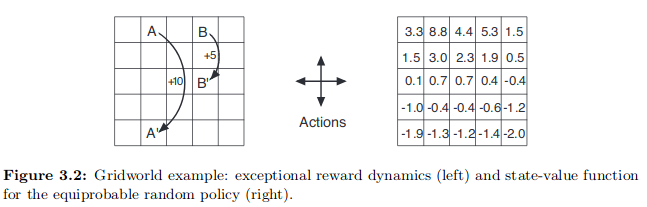

In [18]:
from IPython.display import Image
Image(filename='/home/jfp15b/Documents/reinforcement-learning/BookNotes/Screenshot from 2019-02-28 15-24-19.png')

The leftmost part of the figure shows the square gridworld finite MDP. Each cell of the grid corresponds to a state of the environment. In each cell, there are four possible actions. Can move up, down, left, or right. Taking one of these actions causes the agent to move one cell in that direction on the grid. An action that would remove the agent from the grid instead leave its location unchanged but they have a reward of -1. Other actions give a reward of 0, except for the actions that move the agent out of the special states **A** and **B**. Starting from state **A**, all four possible actions will give a reward of +10 and take the agent into state **A'**. Starting in state **B**, all of the possible actions have a reward of +5 and take the agent into state **B'**. Assume the agent picks actions with equal probability in all states. The right of figure 3.2 shows shows $v_\pi$ for this policy, for discounted reward case with $\gamma = 0.9$. This value function was computed by solving the system of linear equations (3.14). The negative values near the bottom edge are the result of the higher probability of hitting the edge of the gridworld and receiving reward of -1. State **A** is the best state under this policy, but the expected return for this state is less than 10 because after the agent enters state **A**, it is returned to **A'**, where it is likely to hit the edge of the grid. State B is valued more than 5 because after the agent reaches **B** it is taken to **B'**, which also has a positive value. At **B'** the expected negative reward for the possibility of hitting the edge of the grid is compensated for by the expected reward for the possibility of running into A or B.

### 3.6 Optimal Policies and Optimal Value Functions

"Solving an RL task means, roughly, finding a policy that achieves a lot of reward over the long run." In finite MDPs, we can clearly define an optimal policy like this: Value functions define partial ordering over policies; a policy $\pi$ is said to be better than or equall to a policy $\pi'$ if its expected return is greater than or equal to $\pi'$ expected return in **all states**. 

$\pi \geq \pi' \quad$ if and only if $v_\pi(s) \geq v_{\pi'}(s) \quad \forall \space s \in S$

This is an optimal policy. More than one optimal policy may exist but we denote all of the optimal policies by $\pi_*$. The $\pi_*$ share the same state-value function, called the optimal state-value function, denoted by $v_*$, and defined as:

$v_*(s) \stackrel {.}{=} max_\pi v_\pi(s) \quad \forall \space s \in S \quad (3.15)$

Optimal policies also share the same optimal action-value function, denoted $q_*$, and defined:

$q_*(s, a) \stackrel{.}{=} max_\pi q_\pi(s,a) \quad\forall \space s \in S, a \in A \quad (3.16)$

For a state-action pair (s,a) this function gives us the return we expect when taking action a in state s and afterwards following an optimal policy. So, we can write $q_*$ in terms of $v_*$:

$q_*(s,a) = \mathbb E[R_{t+1} + \gamma v_*(S_{t+1}) | S_t = s, A_t = a]$

**Example 3.8: Solving the Gridworld**

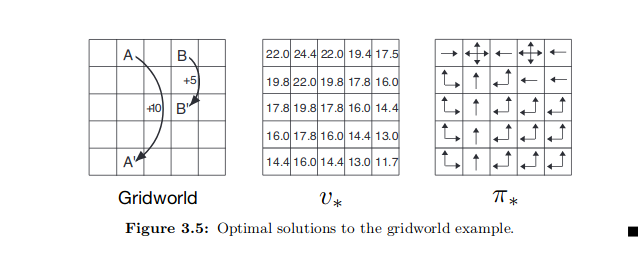

In [19]:
from IPython.display import Image
Image(filename='/home/jfp15b/Documents/reinforcement-learning/BookNotes/Screenshot from 2019-02-28 16-04-03.png')

Imagine solve the Bellman equation for $v_*$ for gridworld. State A gives reward of +10 and transition to **A'**. State **B** gives reward of +5 and transition to state **B'**. Middle and right of the figure show the optimal value function and the corresponding optimal policy. When there are multiple arrows in a cell, each action is equally optimal.

### 3.7 Optimality and Approximation

In practice, an agent rarely learns an optimal policy. We normally don't have the computational power to calculate optimal policies for the problems we are interested in. Even if we have a complete and accurate model of the environment and its dynamics, usually we still can't compute the optimal policy because our state-space is too large. The computational power available to the agent is always a critical problem facing it, especially the amount of compute the agent can do in a single time-step. The available memory is also important, often a lot of memory is needed to store approximations of the model, policies, and value functions. When solving a task with a small and finite state set, we can use a tabular method by computing an approximation for each state and storing these approximations in an array. 

'Our framing of the reinforcement learning problem forces us to settle for approximations.' But, it also gives us unique chances to develop very good approximations. i.e., when we are approximating optimal behavior, there might be many states the agent is so unlikely to face that choosing poor actions for those states has made little change on the amount of reward the agent receives. 'Tesauro's backgammon player, for example, plays with exceptional skill even though it might make very bad decisions on board configurations that never occur against experts.' It is quite possible that the TD-Gammon player makes very poor choices for a large fraction of the game's state set. The online aspect of RL makes it possible to work harder to develop good value approximations for states that are encountered frequently than for states that are encountered rarely. This is an important property that distinguishes RL from other methods for approximately solving MDPs.